In [31]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm_notebook as tqdm

import pickle
import joblib

In [32]:
data = pd.read_csv('df_to_model.csv').set_index('date')

In [33]:
data.head()

,btc_price,btc_volume,eth_price,eth_volume,bnb_price,bnb_volume,vet_price,vet_volume,btt_price,btt_volume,hot_price,hot_volume
date,,,,,,,,,,,,
2013-04-28,135.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04-29,141.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04-30,135.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,117.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-02,103.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
data.index.max()

'2021-05-05'

Lets try to predict hot price and verify if it can be predicted by past information from other coins. For this we will drop its volume and create some lagged values.

In [35]:
data = data.loc[data.hot_price!=0]
data = data.sort_index()

In [36]:
X = data.drop(columns = ['hot_price', 'hot_volume'])
y = data[['hot_price']]

In [37]:
lag_1 = X.shift(1)
lag_1.columns = ['lagged_1_' + column for column in X.columns]

lag_2 = X.shift(2)
lag_2.columns = ['lagged_2_' + column for column in X.columns]

lag_3 = X.shift(3)
lag_3.columns = ['lagged_3_' + column for column in X.columns]

lag_4 = X.shift(4)
lag_4.columns = ['lagged_4_' + column for column in X.columns]

lag_5 = X.shift(4)
lag_5.columns = ['lagged_5_' + column for column in X.columns]

In [38]:
X_lagged = (
    lag_1.iloc[5:]
    .join(lag_2.iloc[5:])
    .join(lag_3.iloc[5:])
    .join(lag_4.iloc[5:])
    .join(lag_5.iloc[5:])
)

In [39]:
X_lagged.head()

,lagged_1_btc_price,lagged_1_btc_volume,lagged_1_eth_price,lagged_1_eth_volume,lagged_1_bnb_price,lagged_1_bnb_volume,lagged_1_vet_price,lagged_1_vet_volume,lagged_1_btt_price,lagged_1_btt_volume,...,lagged_5_btc_price,lagged_5_btc_volume,lagged_5_eth_price,lagged_5_eth_volume,lagged_5_bnb_price,lagged_5_bnb_volume,lagged_5_vet_price,lagged_5_vet_volume,lagged_5_btt_price,lagged_5_btt_volume
date,,,,,,,,,,,,,,,,,,,,,
2018-05-05,9551.135184,1.228125e+09,781.425780,1.005515e+09,15.448140,1.583041e+05,0.0,0.0,0.0,0.0,...,9198.189510,2.508704e+09,662.732736,1.271088e+09,14.246400,5.727836e+07,0.0,0.0,0.0,0.0
2018-05-06,9634.538226,2.695999e+09,777.907647,1.967183e+09,14.237159,5.263799e+07,0.0,0.0,0.0,0.0,...,9024.387512,2.661071e+09,665.225786,1.342793e+09,14.060865,5.595434e+07,0.0,0.0,0.0,0.0
2018-05-07,9766.244485,2.617991e+09,807.067329,1.617672e+09,14.291985,5.092181e+07,0.0,0.0,0.0,0.0,...,9122.653014,2.179559e+09,676.552564,1.153897e+09,14.249384,5.661672e+07,0.0,0.0,0.0,0.0
2018-05-08,9583.871746,2.626418e+09,785.892744,1.742487e+09,13.900460,5.472827e+07,0.0,0.0,0.0,0.0,...,9551.135184,1.228125e+09,781.425780,1.005515e+09,15.448140,1.583041e+05,0.0,0.0,0.0,0.0
2018-05-09,9308.265026,2.767086e+09,748.813141,2.808728e+09,13.685279,4.355853e+07,0.0,0.0,0.0,0.0,...,9634.538226,2.695999e+09,777.907647,1.967183e+09,14.237159,5.263799e+07,0.0,0.0,0.0,0.0


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_lagged, y.iloc[5:], test_size = 0.2, random_state = 42)

In [41]:
X_train.head()

,lagged_1_btc_price,lagged_1_btc_volume,lagged_1_eth_price,lagged_1_eth_volume,lagged_1_bnb_price,lagged_1_bnb_volume,lagged_1_vet_price,lagged_1_vet_volume,lagged_1_btt_price,lagged_1_btt_volume,...,lagged_5_btc_price,lagged_5_btc_volume,lagged_5_eth_price,lagged_5_eth_volume,lagged_5_bnb_price,lagged_5_bnb_volume,lagged_5_vet_price,lagged_5_vet_volume,lagged_5_btt_price,lagged_5_btt_volume
date,,,,,,,,,,,,,,,,,,,,,
2018-05-07,9766.244485,2.617991e+09,807.067329,1.617672e+09,14.291985,5.092181e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,...,9122.653014,2.179559e+09,676.552564,1.153897e+09,14.249384,5.661672e+07,0.000000,0.000000e+00,0.000000,0.000000e+00
2018-05-11,9248.960396,2.363841e+09,743.639816,1.517876e+09,14.550455,7.902337e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,...,9583.871746,2.626418e+09,785.892744,1.742487e+09,13.900460,5.472827e+07,0.000000,0.000000e+00,0.000000,0.000000e+00
2019-12-16,7081.740255,1.949776e+10,141.844865,6.322939e+09,14.367813,1.604249e+08,0.005468,7.769884e+07,0.000312,7.643433e+07,...,7197.426826,1.801694e+10,143.122979,5.883082e+09,14.749628,1.665882e+08,0.006058,7.965008e+07,0.000291,5.640098e+07
2020-01-29,8879.335549,3.966154e+10,169.736436,1.243546e+10,17.635344,2.309468e+08,0.005776,1.285588e+08,0.000357,6.713877e+07,...,8432.096676,3.069173e+10,162.409480,1.104350e+10,17.025803,2.258828e+08,0.005574,1.222548e+08,0.000347,6.816687e+07
2020-08-24,11676.385305,1.957278e+10,395.885018,1.061298e+10,22.175839,2.077040e+08,0.018295,1.502142e+08,0.000429,2.815055e+07,...,11733.278971,2.338420e+10,406.574469,1.285473e+10,22.307583,2.409817e+08,0.017845,2.027235e+08,0.000470,3.616012e+07


In [42]:
RFR = RandomForestRegressor()

In [43]:
RFR.fit(X_train, y_train)

<ipython-input-43-9be308012765>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


RandomForestRegressor()

In [44]:
predictions = RFR.predict(X_test)

In [45]:
print('Mean Squared Error: ', mean_squared_error(y_test, predictions))
print('r2_score: ', r2_score(y_test, predictions))

Mean Squared Error:  2.49206176762166e-07
r2_score:  0.9757922037006618


In [46]:
to_plot = y_test.copy()
to_plot['predictions'] = predictions

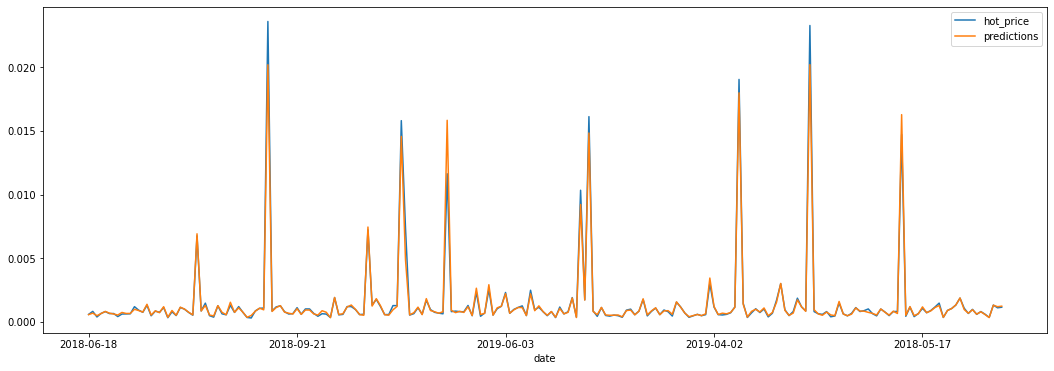

In [47]:
to_plot.plot(figsize = [18, 6])
plt.show()

# Parameter Tuning

## N_estimators

In [48]:
nb_estim = [50, 100, 150, 200, 300, 350, 400, 450]

In [49]:
for n in nb_estim:
    RFR = RandomForestRegressor(n_estimators = n, random_state = 42)
    RFR.fit(X_train, y_train)
    predictions = RFR.predict(X_test)
    print(n)
    print('Mean Squared Error: ', mean_squared_error(y_test, predictions))
    print('r2_score: ', r2_score(y_test, predictions))

<ipython-input-49-5873d98c287a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


50
Mean Squared Error:  2.509880615811846e-07
r2_score:  0.9756191120651007


<ipython-input-49-5873d98c287a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


100
Mean Squared Error:  2.740927814572531e-07
r2_score:  0.9733747280791976


<ipython-input-49-5873d98c287a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


150
Mean Squared Error:  2.6401774350568594e-07
r2_score:  0.9743534135580588


<ipython-input-49-5873d98c287a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


200
Mean Squared Error:  2.423393489469927e-07
r2_score:  0.9764592448275395


<ipython-input-49-5873d98c287a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


300
Mean Squared Error:  2.3741952489705875e-07
r2_score:  0.9769371547251865


<ipython-input-49-5873d98c287a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


350
Mean Squared Error:  2.418916999776662e-07
r2_score:  0.9765027292836789


<ipython-input-49-5873d98c287a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


400
Mean Squared Error:  2.366682981397812e-07
r2_score:  0.9770101286159265


<ipython-input-49-5873d98c287a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


450
Mean Squared Error:  2.3826765630864758e-07
r2_score:  0.9768547675519889


## Min_samples_split

In [50]:
min_samp_spl = [2, 3, 4, 5]

In [51]:
for n in min_samp_spl:
    RFR = RandomForestRegressor(n_estimators = 400, min_samples_split = n, random_state = 42)
    RFR.fit(X_train, y_train)
    predictions = RFR.predict(X_test)
    print(n)
    print('Mean Squared Error: ', mean_squared_error(y_test, predictions))
    print('r2_score: ', r2_score(y_test, predictions))

<ipython-input-51-ee366a5d92cf>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


2
Mean Squared Error:  2.366682981397812e-07
r2_score:  0.9770101286159265


<ipython-input-51-ee366a5d92cf>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


3
Mean Squared Error:  2.3544382030217134e-07
r2_score:  0.9771290739424471


<ipython-input-51-ee366a5d92cf>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


4
Mean Squared Error:  2.517129183508244e-07
r2_score:  0.9755486997452553


<ipython-input-51-ee366a5d92cf>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


5
Mean Squared Error:  2.6255045237545045e-07
r2_score:  0.9744959456784663


## Min_samples_leaf

In [52]:
min_samp_leaf = [1, 2, 3, 4, 5, 6, 7, 8]

In [53]:
for n in min_samp_leaf:
    RFR = RandomForestRegressor(n_estimators = 400, min_samples_split = 3, min_samples_leaf = n, random_state = 42)
    RFR.fit(X_train, y_train)
    predictions = RFR.predict(X_test)
    print(n)
    print('Mean Squared Error: ', mean_squared_error(y_test, predictions))
    print('r2_score: ', r2_score(y_test, predictions))

<ipython-input-53-91e1351d279f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


1
Mean Squared Error:  2.3544382030217134e-07
r2_score:  0.9771290739424471


<ipython-input-53-91e1351d279f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


2
Mean Squared Error:  2.591416381622171e-07
r2_score:  0.9748270766366488


<ipython-input-53-91e1351d279f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


3
Mean Squared Error:  2.735929060149202e-07
r2_score:  0.9734232857957047


<ipython-input-53-91e1351d279f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


4
Mean Squared Error:  2.753508461682663e-07
r2_score:  0.973252520136155


<ipython-input-53-91e1351d279f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


5
Mean Squared Error:  2.800578568698838e-07
r2_score:  0.9727952828488453


<ipython-input-53-91e1351d279f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


6
Mean Squared Error:  2.719585070584863e-07
r2_score:  0.9735820507088512


<ipython-input-53-91e1351d279f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


7
Mean Squared Error:  2.759289705320313e-07
r2_score:  0.9731963613482167


<ipython-input-53-91e1351d279f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


8
Mean Squared Error:  2.858285685870081e-07
r2_score:  0.9722347180363461


In [54]:
RFR = RandomForestRegressor(n_estimators = 400, min_samples_split = 3, min_samples_leaf = 1, random_state = 42)
RFR.fit(X_train, y_train)
predictions = RFR.predict(X_test)
print('Mean Squared Error: ', mean_squared_error(y_test, predictions))
print('r2_score: ', r2_score(y_test, predictions))

<ipython-input-54-508cc065c618>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_train, y_train)


Mean Squared Error:  2.3544382030217134e-07
r2_score:  0.9771290739424471


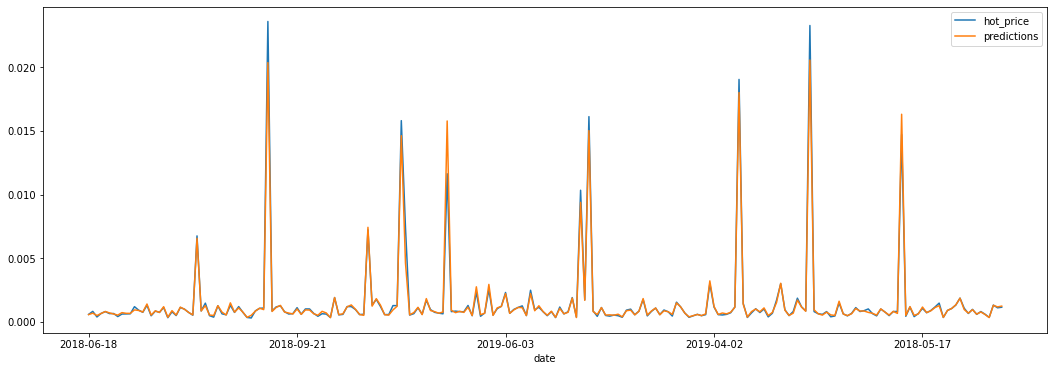

In [55]:
to_plot = y_test.copy()
to_plot['predictions'] = predictions
to_plot.sort_values(by='date')
to_plot.plot(figsize = [18, 6])
plt.show()

# Feature importance

Feature ranking:
1. feature lagged_1_btt_price (0.360074)
2. feature lagged_5_btt_price (0.162685)
3. feature lagged_4_btt_price (0.131355)
4. feature lagged_2_btt_price (0.109499)
5. feature lagged_3_btt_price (0.042020)
6. feature lagged_1_vet_price (0.034943)
7. feature lagged_5_vet_price (0.029555)
8. feature lagged_2_vet_price (0.025940)
9. feature lagged_4_vet_price (0.023765)
10. feature lagged_1_btc_price (0.011387)
11. feature lagged_1_bnb_price (0.010992)
12. feature lagged_3_vet_price (0.008754)
13. feature lagged_1_btt_volume (0.005313)
14. feature lagged_5_vet_volume (0.004364)
15. feature lagged_2_btt_volume (0.004165)
16. feature lagged_4_vet_volume (0.003941)
17. feature lagged_1_eth_price (0.003034)
18. feature lagged_3_btc_price (0.002723)
19. feature lagged_3_eth_price (0.002578)
20. feature lagged_2_btc_price (0.002516)
21. feature lagged_2_bnb_price (0.001574)
22. feature lagged_4_btc_price (0.001501)
23. feature lagged_3_bnb_price (0.001476)
24. feature lagged_4_b

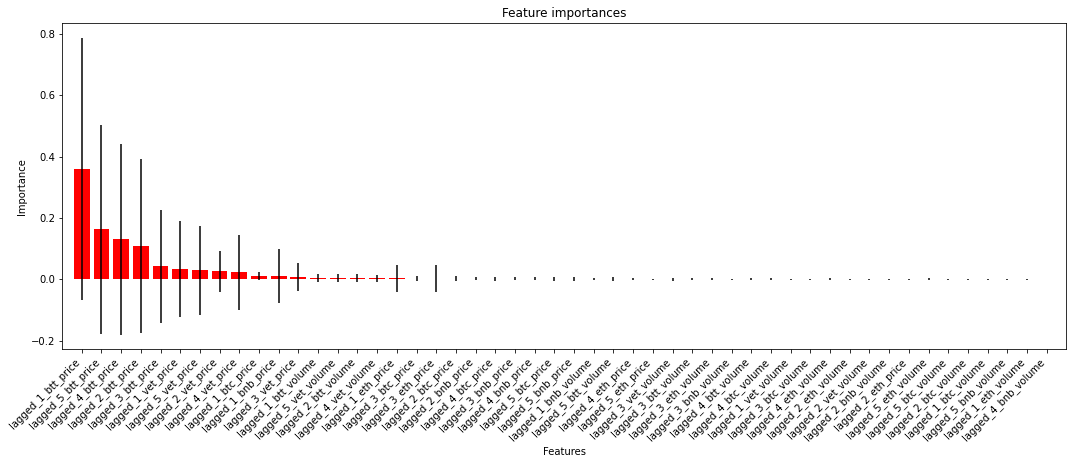

In [56]:
importances = pd.Series(data=RFR.feature_importances_, index = X_train.columns)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)

plt.figure(figsize = (18,6))
plt.title("Feature importances")
plt.bar(x=importances.index[indices], height=importances[indices],
        color="r", yerr=std[indices], align="center");
plt.xticks(range(len(importances.index[indices])), importances.index[indices], rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Features');
plt.ylabel('Importance');

plt.show()

In [59]:
RFR.fit(X_lagged, y.iloc[5:])

<ipython-input-59-7e5e55ef7490>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(X_lagged, y.iloc[5:])


RandomForestRegressor(min_samples_split=3, n_estimators=400, random_state=42)

In [60]:
with open('columns.json', 'w') as fh: json.dump(X_train.columns.tolist(), fh)

with open('dtypes.pickle', 'wb') as fh: pickle.dump(X_train.dtypes, fh)

joblib.dump(RFR, 'RFR.pickle');